# Developer Survey Analysis

The goal is this analysis is to analyze the 2018 survey results and gain relevant insights pertaining to the Data Scientist profession. In particular, we want to see whether they differ from developers. Some questions we are interested in right off the bat are:
- what are the most popular languages/technologies among developers? Among data scientists?
- what are the determinants of job satisfaction? Do data scientists seem more/less satisfied with their jobs, after controlling for confounding variables?
- is it possible to extract different data scientist "archetypes" from this survey? Do they differ from developers as a broader group?

We will leverage descriptive statistics as well as modeling to answer all these questions. We will analyze the results collected by Stack Overflow and made publicly available [here](https://insights.stackoverflow.com/survey).

In [52]:
# We start by loading the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import re
from collections import defaultdict

%matplotlib inline

## Loading the Data

In [2]:
# We first extract the file from its archive and then ingest it into Pandas

zip_ref = zipfile.ZipFile('developer_survey_2018.zip', 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

data_2018 = pd.read_csv('survey_results_public.csv')
schema_2018 = pd.read_csv('survey_results_schema.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Initial Assessment

In [3]:
print('The 2018 survey results have {} respondents and {} variables'.format(str(data_2018.shape[0]),
                            str(data_2018.shape[1])))

The 2018 survey results have 98855 respondents and 129 variables


In [4]:
# The schema will serve as a useful guide
schema_2018.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,Hobby,Do you code as a hobby?
2,OpenSource,Do you contribute to open source projects?
3,Country,In which country do you currently reside?
4,Student,"Are you currently enrolled in a formal, degree..."


In [5]:
# We can print out the data type of each column, since it will inform our analysis
data_2018.dtypes

Respondent                       int64
Hobby                           object
OpenSource                      object
Country                         object
Student                         object
Employment                      object
FormalEducation                 object
UndergradMajor                  object
CompanySize                     object
DevType                         object
YearsCoding                     object
YearsCodingProf                 object
JobSatisfaction                 object
CareerSatisfaction              object
HopeFiveYears                   object
JobSearchStatus                 object
LastNewJob                      object
AssessJob1                     float64
AssessJob2                     float64
AssessJob3                     float64
AssessJob4                     float64
AssessJob5                     float64
AssessJob6                     float64
AssessJob7                     float64
AssessJob8                     float64
AssessJob9               

The 2018 survey gathered responses from almost 100,000 people, on 129 questions. It will be really useful to answer the questions at hand. We have both numeric and categorical variables, which we will need to encode in order to be able to plug them in machine learning models.

## Data Preparation

### Missing Values

We assess the presence of missing values, and deal with them.

In [6]:
# We assess the columns
data_2018.isnull().mean().sort_values(ascending = False)

TimeAfterBootcamp              0.932710
MilitaryUS                     0.840362
HackathonReasons               0.740114
ErgonomicDevices               0.655475
AdBlockerReasons               0.618178
StackOverflowJobsRecommend     0.612392
JobEmailPriorities1            0.532517
JobEmailPriorities2            0.532517
JobEmailPriorities3            0.532517
JobEmailPriorities4            0.532517
JobEmailPriorities6            0.532517
JobEmailPriorities5            0.532517
JobEmailPriorities7            0.532517
ConvertedSalary                0.517455
JobContactPriorities3          0.507299
JobContactPriorities4          0.507299
JobContactPriorities2          0.507299
JobContactPriorities1          0.507299
JobContactPriorities5          0.507299
Salary                         0.488362
SalaryType                     0.483385
FrameworkWorkedWith            0.477821
TimeFullyProductive            0.475272
AdBlockerDisable               0.444661
FrameworkDesireNextYear        0.441424


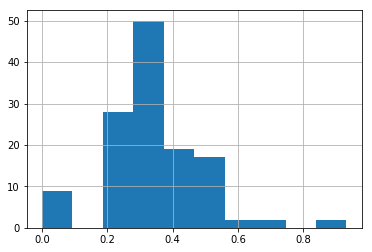

In [7]:
data_2018.isnull().mean(axis = 0).hist();

In [8]:
# We drop the columns with more than 60% of missing values
data_2018 = data_2018.loc[:, data_2018.isnull().mean() < 0.6]

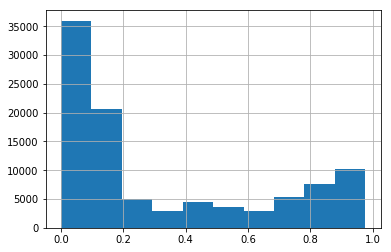

In [9]:
# We now assess the rows
data_2018.isnull().mean(axis = 1).hist();

In [10]:
# We drop the rows with more than 80% of missing values
data_2018 = data_2018.loc[data_2018.isnull().mean(axis = 1) < 0.8,:]

In [11]:
print('After removing missing values, the 2018 survey results have {} respondents and {} variables'.format(str(data_2018.shape[0]),
                            str(data_2018.shape[1])))

After removing missing values, the 2018 survey results have 82184 respondents and 123 variables


We assess missing values in rows and columns. We remove columns which have more than 50% of missing values, as well as rows that have more than 80% of missing values, for both these groups do not provide us with useful information for our purposes. We are still left with 123 variables and 82,184 respondents. We will probably have to impute or do more cleaning later on, but this is a good first pass for now.

### Duplicate Values

In [12]:
print(data_2018.Respondent.duplicated().sum(), data_2018.duplicated().sum())

0 0


No duplicate values to deal with. 

### Categorical Variables

In [13]:
# We transform the salary variable from a categorical to a numerical variables
data_2018.Salary = pd.to_numeric(data_2018.Salary.str.replace(',', ''), errors = 'coerce')

In [14]:
# Create a numerical representation of JobSatisfaction for predictions later
mapping = dict([(category, code) for code, category in enumerate(data_2018.CareerSatisfaction.unique())])
data_2018.JobSatisfaction = data_2018.JobSatisfaction.map(mapping)

In [15]:
# Create dummy variables for our categorical variables
categorical_cols = data_2018.select_dtypes(include = ["object"]).columns.values.tolist()
data_2018_dummies = pd.get_dummies(data_2018, columns = categorical_cols, dummy_na = True)

In [16]:
# We drop columns which arise from the multiple response nature of the survey, only keeping the most general answer
cols = []

for c in data_2018_dummies.columns:
    if (re.search(r'.*;.*', c)):
        cols.append(c)

data_2018_dummies.drop(cols, axis =1, inplace = True)

Later in our analysis, we will want to use the salary variable, which we thus convert to numeric (it was viewed as categorical due to the thousand separator certain respondents used). We also create a numerical representation of job satisfaction, to be used in multi-class classification later on.

We use one-hot encoding for categorical variables, which will enable us to use them in machine learning models later on. Due to the way certain responses were recorded, we also choose to remove detailed descriptions, only keeping the uppermost level.

### Languages and Frameworks - General Tools

Look overall, and whether there are associations/biases within various groups/professions. Consider using the original dataset vs. the dummy one for this. Focus on the differences between DS and developers.
Create same visualizations as in the example seen in class.

For this particular application, since we are not trying to build a model, we use the dataset before creating dummies for categorical variables. We want to look at languages they've worked with, as well as what they want to learn in the future to see whether there is agreement as well as whether it is possible to discern a trend.

In [35]:
# We start by only keeping non-null elements of the dataframe
data_2018_languages_past = data_2018.loc[data_2018.LanguageWorkedWith.notnull(),:]

In [44]:
# We extract all the possible languages through a helper function

def extract_unique_values(df, column):
    '''
    INPUT:
    df - a dataframe
    column - a column of a dataframe with values separated with a semicolon

    OUTPUT:
    unique_values - a list of unique values present in the column
    '''

    unique_values = []

    for i in df[column].unique():
        for j in i.split(';'):
            if not j in unique_values:
                unique_values.append(j)
    return(unique_values)

languages = extract_unique_values(data_2018_languages_past, 'LanguageWorkedWith')

In [50]:
# Now that we have all the possible values, we use them to create counts for each
# We start by creating a helper function 

def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

languages_overall = data_2018_languages_past.LanguageWorkedWith.value_counts().reset_index()
languages_overall.rename(columns={'index': 'language', 'LanguageWorkedWith': 'count'}, inplace=True)
languages_overall = total_count(languages_overall, 'language', 'count', languages)
languages_overall.set_index('language', inplace=True)

,language,count
2,C,65144
17,Java,63117
18,JavaScript,53282
14,HTML,52173
5,CSS,49603
31,SQL,43588
1,Bash/Shell,30607
27,Python,29567
3,C#,26264
25,PHP,23313


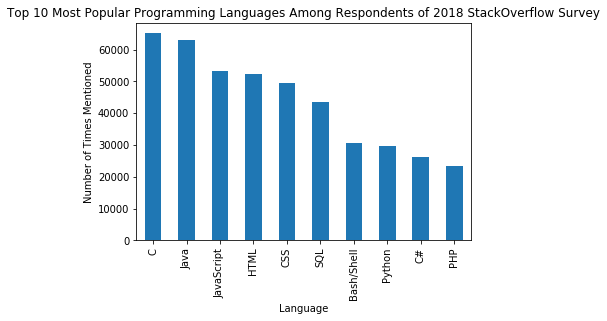

In [65]:
# We can now plot the popularity of various languages overall
# We only keep the top 10
languages_overall.head(10).plot(kind = 'bar', legend = None);
plt.title("Top 10 Most Popular Programming Languages Among Respondents of 2018 StackOverflow Survey");
plt.xlabel("Language");
plt.ylabel("Number of Times Mentioned");

In [92]:
# We create two datasets, one for data scientists/analysts and one for the rest
# We must first filter out the NA values in the DevType column to do so

data_2018_languages_past.dropna(subset = ['DevType'], axis = 0, inplace = True)
pattern = ['Data or business analyst' , 'Data scientist or machine learning specialist']

data_scientists = data_2018_languages_past.DevType.str.contains('|'.join(pattern))
data_2018_languages_past_DS = data_2018_languages_past.loc[data_scientists,"LanguageWorkedWith"]
data_2018_languages_past_noDS = data_2018_languages_past.loc[data_scientists == False,"LanguageWorkedWith"]

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
# We then repeat the prior analysis for these two groups

### Determinants of job satisfaction

Linear Regression model. Impute missing values. Only a subset of all features? Compare data scientists vs. developers in general. Start by only looking at on average, and then control for other values. Deal with categorical variables here - rather than have all the values for dev_type, create a dummy if data scientist/analyst or not and drop dev_type.

### Archetypes

Subset only a few variables of interest (salary, education, languages used, big/small company, job satisfaction, experience) Drill in within the data scientist profession in the US, and repeat the analysis for developers, comparing the two. Use the dummy variable for DS here, and do the clustering on the two subsets.